In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Derive, Beta, Variable, log, exp
from biogeme import models
from biogeme import results as res

In [2]:
#data_file = "http://transp-or.epfl.ch/data/lpmc.dat"
data_file='lpmc10.dat'
lpmc = pd.read_csv(data_file, sep='\t')
lpmc

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,20,5,1,0,4,3,1,5,0.0,1,...,0.381667,0.000000,0.062222,0.000000,0,0.117222,0.00,0.41,0.0,0.097156
1,41,9,3,0,4,3,1,5,0.0,1,...,0.146944,0.000000,0.225000,0.000000,0,0.200833,0.00,0.48,0.0,0.378976
2,69,13,2,1,4,3,1,1,1.0,1,...,0.029444,0.083333,0.735833,0.398056,3,0.716944,6.00,2.16,0.0,0.582720
3,102,20,2,0,2,3,1,1,1.0,1,...,0.339722,0.183333,0.116667,0.266667,1,0.250833,3.00,0.89,0.0,0.170543
4,105,21,0,1,4,3,1,1,1.0,1,...,0.126389,0.000000,0.150000,0.000000,0,0.125833,1.50,0.37,0.0,0.154525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,80998,17591,0,5,4,3,1,5,0.0,3,...,0.189167,0.000000,0.117778,0.000000,0,0.082500,0.00,0.22,10.5,0.239057
4996,81000,17592,0,0,3,3,6,5,0.0,3,...,0.105278,0.000000,0.220278,0.000000,0,0.213611,0.00,0.52,0.0,0.412224
4997,81015,17597,0,3,4,3,1,5,0.0,3,...,0.343056,0.000000,0.177500,0.000000,0,0.189444,0.00,0.76,0.0,0.086510
4998,81041,17604,2,4,3,1,1,2,0.0,3,...,0.344444,0.316667,0.000000,0.083333,1,0.386111,1.05,0.98,0.0,0.340288


In [4]:
# cost_driving = cost_driving_fuel + cost_driving_ccharge #total costs of driving
# dur_public = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int #total duration of public transportation
# lpmc['cost_driving']=lpmc['cost_driving_ccharge']+lpmc['cost_driving_fuel']
# lpmc['dur_public']=lpmc['dur_pt_access']+lpmc['dur_pt_rail']+lpmc['dur_pt_bus']+lpmc['dur_pt_int']

In [3]:
database = db.Database('trips', lpmc)

In [4]:
lpmc.columns

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent'],
      dtype='object')

In [5]:
# define variables
for col in lpmc.columns:
    globals()[col]=Variable(col)

In [6]:
cost_driving = database.DefineVariable('cost_driving',cost_driving_fuel + cost_driving_ccharge)
dur_public = database.DefineVariable('dur_public', dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int)

# Choice availability

In [7]:
law_violators =(lpmc['driving_license']==0 )& (lpmc['travel_mode']==4)
law_violators.value_counts()

False    4511
True      489
dtype: int64

# Model 0
We include alternative specific constants and generic time and cost parameters.

In [8]:
# asc_walk = Beta('asc_walk', 0, None, None, 1)
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

In [9]:
beta_cost = Beta('beta_cost', 0, None, None, 0)
beta_time = Beta('beta_time', 0, None, None, 0)

In [10]:
V_walk = beta_time * dur_walking
V_cycling = asc_cycling + beta_time * dur_cycling
V_driving = asc_driving + beta_time * dur_driving + beta_cost * cost_driving
V_public = asc_public + beta_time * dur_public + beta_cost * cost_transit

In [11]:
V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

In [12]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_base'

In [13]:
results0 = biogeme.estimate()

[15:47:26] < Warning >   Cannot read file __model_base.iter. Statement is ignored.


In [14]:
print(results0.printGeneralStatistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4722.972
Likelihood ratio test for the init. model:	4417
Rho-square for the init. model:	0.319
Rho-square-bar for the init. model:	0.318
Akaike Information Criterion:	9455.944
Bayesian Information Criterion:	9488.53
Final gradient norm:	1.0691E-03
Nbr of threads:	16



In [15]:
results0.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-3.660824,0.100795,-36.319469,0.0
asc_driving,-1.335138,0.076403,-17.474949,0.0
asc_public,-0.559066,0.052620,-10.624628,0.0
beta_cost,-0.149850,0.013780,-10.874260,0.0
beta_time,-5.410269,0.188336,-28.726735,0.0


In [16]:
file_0= open("results0.txt","w+")
file_0.write(results0.getLaTeX())
file_0.close()

# Model 1
We define alternative specific time parameters.

In [17]:
beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycling = Beta('beta_time_cycling', 0, None, None, 0)
beta_time_driving = Beta('beta_time_driving', 0, None, None, 0)
beta_time_public = Beta('beta_time_public', 0, None, None, 0)

In [18]:
V_walk = beta_time_walk * dur_walking
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_driving = asc_driving + beta_time_driving * dur_driving + beta_cost * cost_driving
V_public = asc_public + beta_time_public * dur_public + beta_cost * cost_transit

In [19]:
V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

In [20]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_1'

In [21]:
results1 = biogeme.estimate()

[15:49:09] < Warning >   Cannot read file __model_1.iter. Statement is ignored.


In [22]:
print(results1.printGeneralStatistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4412.008
Likelihood ratio test for the init. model:	5038.928
Rho-square for the init. model:	0.363
Rho-square-bar for the init. model:	0.362
Akaike Information Criterion:	8840.016
Bayesian Information Criterion:	8892.153
Final gradient norm:	2.5518E-02
Nbr of threads:	16



In [23]:
results1.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.590519,0.179036,-25.640219,0.0
asc_driving,-2.072023,0.120163,-17.243377,0.0
asc_public,-2.439478,0.121947,-20.004412,0.0
beta_cost,-0.141780,0.015193,-9.331745,0.0
beta_time_cycling,-5.195891,0.423907,-12.257160,0.0
beta_time_driving,-5.875433,0.359795,-16.329946,0.0
beta_time_public,-3.200593,0.230746,-13.870609,0.0
beta_time_walk,-8.367591,0.360100,-23.236825,0.0


In [24]:
file_1= open("results1.txt","w+")
file_1.write(results1.getLaTeX())
file_1.close()

## Comparing Models 0 and 1

In [27]:
general_statistics_model_0 = results0.getGeneralStatistics()
print(results0.printGeneralStatistics())

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4722.972
Final log likelihood:	-4722.972
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00106
Akaike Information Criterion:	9455.944
Bayesian Information Criterion:	9488.53
Final gradient norm:	3.2270E-03
Nbr of threads:	4



In [28]:
general_statistics_model_1 = results1.getGeneralStatistics()
print(results1.printGeneralStatistics())

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4412.008
Final log likelihood:	-4412.008
Likelihood ratio test for the init. model:	2.305715e-07
Rho-square for the init. model:	2.61e-11
Rho-square-bar for the init. model:	-0.00181
Akaike Information Criterion:	8840.016
Bayesian Information Criterion:	8892.154
Final gradient norm:	2.1274E-02
Nbr of threads:	4



### Likelihood ratio test

$H_O$: $\beta\_time\_walk=\beta\_time\_driving=\beta\_time\_public=\beta\_time\_cycling$

Because model 0 is an restricted version of model 1, we can apply the likelihood ratio test.

In [25]:
alpha=0.05
results1.likelihood_ratio_test(results0, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=621.9276889295215, threshold=7.814727903251179)

According to the test result, the null hypothesis is rejected at the 5% level.

# Model 2

We include
1. One alternative attribute: fueltype for driving.
2. One socio-economic characteristics: driving license.

<!-- Model 2 specification:

$ V_{walk}=ASC_{walk}+\beta_{time\_walk}time_{walk} $

$ V_{cycling}=ASC_{cycling}+\beta_{time\_cycle}time_{cycle} $

$ V_{public}=ASC_{public}+\beta_{time\_public}time_{public}+\beta_{cost}cost_{public}+\beta_{traffic}driving\_traffic\_percent$

$ V_{driving}=ASC_{driving}+\beta_{time\_driving}time_{driving}+\beta_{cost}cost_{driving}+\beta_{driving_license}drivinglicense$ -->


In [26]:
# asc_walk = Beta('asc_walk', 0, None, None, 1) 
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

In [26]:
beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycling = Beta('beta_time_cycling', 0, None, None, 0)
beta_time_driving = Beta('beta_time_driving', 0, None, None, 0)
beta_time_public = Beta('beta_time_public', 0, None, None, 0)

beta_cost = Beta('beta_cost', 0, None, None, 0)

# alternative attribute
beta_traffic = Beta('beta_driving_traffic_percent',0, None, None,0)
# social economics characteristics
beta_drivinglicense = Beta('beta_drivinglicense',0,None,None,0)

In [45]:
# model 2 specification 
V_walk = beta_time_walk * dur_walking
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_public = asc_public + beta_time_public * dur_public + beta_cost * cost_transit
V_driving = asc_driving +beta_drivinglicense*driving_license + beta_time_driving * dur_driving + beta_cost * cost_driving + \
            beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)


In [46]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_2'

In [47]:
results2 = biogeme.estimate()

[16:01:13] < Warning >   Cannot read file __model_2.iter. Statement is ignored.


In [48]:
print(results2.printGeneralStatistics())

Number of estimated parameters:	10
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4116.139
Likelihood ratio test for the init. model:	5630.666
Rho-square for the init. model:	0.406
Rho-square-bar for the init. model:	0.405
Akaike Information Criterion:	8252.278
Bayesian Information Criterion:	8317.45
Final gradient norm:	1.8355E-02
Nbr of threads:	16



In [49]:
results2.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.660981,0.186396,-25.005737,0.000000e+00
asc_driving,-2.407648,0.137885,-17.461337,0.000000e+00
asc_public,-2.619489,0.128107,-20.447660,0.000000e+00
beta_cost,-0.089926,0.015067,-5.968294,2.397466e-09
beta_driving_traffic_percent,-2.958441,0.235979,-12.536867,0.000000e+00
beta_drivinglicense,1.441437,0.071179,20.250883,0.000000e+00
beta_time_cycling,-4.784378,0.438025,-10.922614,0.000000e+00
beta_time_driving,-4.418347,0.370430,-11.927604,0.000000e+00
beta_time_public,-2.830400,0.235259,-12.030980,0.000000e+00
beta_time_walk,-8.374844,0.370402,-22.610177,0.000000e+00


In [50]:
file_2= open("results2.txt","w+")
file_2.write(results2.getLaTeX())
file_2.close()

In [38]:
# results2.data.htmlFileName

## Compare model 2 and 1
Since model 1 is a restricted version of model 2, we perform a likelihood ratio test. Or we can simply perform t-test on the coefficients $\beta\_driving\_license$ and $\beta\_traffic$, as given by the estimation table.

In [51]:
results2.likelihood_ratio_test(results1, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=591.7382206724633, threshold=5.991464547107979)

Thus, model 2 is preferred to model 1.

# Model 3

We perform box-cox transformation on travel time for every alternatives.

In [52]:
# define lambda
lambda_boxcox = Beta('lambda_boxcox', 1, None, None, 0)
boxcox_time_1 = models.boxcox(dur_walking, lambda_boxcox)
boxcox_time_2 = models.boxcox(dur_cycling, lambda_boxcox)
boxcox_time_3 = models.boxcox(dur_public, lambda_boxcox)
boxcox_time_4 = models.boxcox(dur_driving, lambda_boxcox)

In [53]:
# model 3 specification 
V_walk = beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving \
            +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

biogeme.modelName = 'model_3'

In [54]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3'
results3 = biogeme.estimate()
print(results3.printGeneralStatistics())

[16:03:05] < Warning >   Cannot read file __model_3.iter. Statement is ignored.
Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4071.611
Likelihood ratio test for the init. model:	5719.722
Rho-square for the init. model:	0.413
Rho-square-bar for the init. model:	0.411
Akaike Information Criterion:	8165.221
Bayesian Information Criterion:	8236.91
Final gradient norm:	2.1995E-02
Nbr of threads:	16



In [55]:
results3.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-1.804932,0.279523,-6.457183,1.066700e-10
asc_driving,0.814865,0.273886,2.975197,2.928003e-03
asc_public,1.974105,0.173882,11.353111,0.000000e+00
beta_cost,-0.091493,0.014584,-6.273438,3.531622e-10
beta_driving_traffic_percent,-2.601050,0.240714,-10.805545,0.000000e+00
beta_drivinglicense,1.445317,0.071811,20.126770,0.000000e+00
beta_time_cycling,-3.026531,0.276831,-10.932758,0.000000e+00
beta_time_driving,-2.650897,0.270057,-9.816063,0.000000e+00
beta_time_public,-2.224312,0.191608,-11.608648,0.000000e+00
beta_time_walk,-5.377137,0.298874,-17.991325,0.000000e+00


In [56]:
file_3= open("results3.txt","w+")
file_3.write(results3.getLaTeX())
file_3.close()

## Compare model 3 and 2
Under the null hypothesis that $\lambda=1$, the statistic $$\frac{\widehat{\lambda}-1}{\widehat{\sigma}_\lambda}$$ follows approximatively a $N(0, 1)$.  
Thus, we perform a t-test on $\lambda$.

In [57]:
estimated_parameters_3=results3.getEstimatedParameters()
t_test_lambda = (estimated_parameters_3.loc['lambda_boxcox','Value'] - 1) / estimated_parameters_3.loc['lambda_boxcox', 'Rob. Std err']
t_test_lambda

-11.12116823094468

In [46]:
from scipy.stats import norm
from biogeme.results import calcPValue

In [47]:
norm.ppf(.95)

1.6448536269514722

In [48]:
calcPValue(t_test_lambda)

0.0

Because the $p-value<0.05$, we reject the null hypothesis that $\lambda=1$. Thus, model 3 is preferred.

Though not exactly relevant as one is not the linear restriction of the other, we also perform a likelihood ratio test to check.

In [49]:
alpha = 0.05
results3.likelihood_ratio_test(results2, alpha)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=272.0556496349345, threshold=3.841458820694124)

A more general way is to perform a **Davidson and McKinnon J test**  on model 2 and 3. 

# Model 4.a

We define Model 4.a as a nested version of Model 3 where we regroup motorized (public transports and car) as a nest, walking and cycling as another nest.

In [62]:
results4.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
MU_motorized,1.892844,0.245826,7.699925,1.354472e-14
MU_non_motorized,0.686478,0.071778,9.563958,0.000000e+00
asc_cycling,-0.316613,0.294821,-1.073916,2.828603e-01
asc_driving,2.371441,0.301763,7.858618,3.774758e-15
asc_public,3.128218,0.235327,13.293061,0.000000e+00
beta_cost,-0.039085,0.010655,-3.668285,2.441831e-04
beta_driving_traffic_percent,-1.486760,0.240186,-6.190039,6.014937e-10
beta_drivinglicense,0.895696,0.107427,8.337745,0.000000e+00
beta_time_cycling,-1.323322,0.259310,-5.103240,3.338869e-07
beta_time_driving,-1.606233,0.247199,-6.497742,8.153433e-11


Because $\mu_\text{non\_motorized}<1$, we reject the nested model.

# Model 4.b

In [63]:
MU_private = Beta('MU_private', 1, 0, None, 0)
private = MU_private, [1,2,4]
public = 1, [3]
nests = private,public
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_5'
results5 = biogeme.estimate(recycle=True)
results5.getEstimatedParameters()

[16:10:27] < Warning >   Recycling was requested, but no pickle file was found
[16:10:27] < Warning >   Cannot read file __model_5.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
MU_private,0.650852,0.042759,15.221570,0.000000e+00
asc_cycling,-1.516913,0.388054,-3.909025,9.266953e-05
asc_driving,2.213199,0.406244,5.447951,5.095350e-08
asc_public,3.368701,0.358377,9.399888,0.000000e+00
beta_cost,-0.083946,0.016215,-5.176952,2.255398e-07
beta_driving_traffic_percent,-3.188256,0.288127,-11.065462,0.000000e+00
beta_drivinglicense,1.777428,0.100008,17.772867,0.000000e+00
beta_time_cycling,-3.101769,0.319821,-9.698449,0.000000e+00
beta_time_driving,-2.767161,0.286049,-9.673735,0.000000e+00
beta_time_public,-2.645343,0.228022,-11.601266,0.000000e+00


Since $\mu_{\text{private}}<1$, we reject the nested model. 

Therefore, we conclude that model 3 is the preferred model.

# Sampling

## Calculate the weight for each segment

In [64]:
modes = ["walk","cycling","public","driving"]

In [65]:
# Population statistics

census = {
    'male_41_more':  1633263,
    'male_40_less':  2676249,
    'female_41_more':  1765143,
    'female_40_less':  2599058
}

In [66]:
total = sum(census.values())
total

8673713

In [67]:
lpmc["40_less"]=lpmc["age"]<=40
lpmc["40_less"]

0       False
1        True
2        True
3        True
4       False
        ...  
4995    False
4996    False
4997    False
4998     True
4999     True
Name: 40_less, Length: 5000, dtype: bool

In [68]:
# sample statistics
filters = {
    'male_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 0),
    'male_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 0),
    'female_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 1),
    'female_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 1)
}

In [69]:
sample_segments = {
    k: v.sum() for k, v in filters.items()
}
sample_segments

{'male_41_more': 1084,
 'male_40_less': 1256,
 'female_41_more': 1204,
 'female_40_less': 1456}

In [70]:
total_sample = sum(sample_segments.values())
total_sample

5000

The weight $w_g$ associated with segment $g$ is defined as
$$
w_g = \frac{N_g}{N}\frac{S}{S_g}.
$$

In [71]:
# weight associated with each segment
weights = {
    k: census[k] * total_sample / (v * total) 
    for k, v in sample_segments.items()
}
weights

{'male_41_more': 0.86854394680908,
 'male_40_less': 1.2282925990376248,
 'female_41_more': 0.8451199703160228,
 'female_40_less': 1.029009899043413}

In [72]:
# insert weight as a new column to the database lpmc
for k, f in filters.items():
    lpmc.loc[f, 'Weight'] = weights[k] 
lpmc['Weight']

0       0.845120
1       1.029010
2       1.228293
3       1.228293
4       0.868544
          ...   
4995    0.845120
4996    0.845120
4997    0.868544
4998    1.228293
4999    1.029010
Name: Weight, Length: 5000, dtype: float64

In [75]:
Weight = Variable('Weight')

## Calculate predicted market share for each mode

In [168]:
# confirm the preferred model
V_walk = beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving \
            +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

biogeme.modelName = 'model_pref'
biogeme = bio.BIOGEME(database, logprob)

In [169]:
prob_walk = models.logit(V, None, 1)
prob_cycling = models.logit(V, None, 2)
prob_public = models.logit(V, None,3)
prob_driving = models.logit(V, None,4)

In [170]:
simulate = {
    'Weight': Weight,
    'Prob. walk': prob_walk,
    'Prob. cycling': prob_cycling,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving
}

In [107]:
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results3.getBetaValues())

In [108]:
simulated_values

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving
0,0.845120,0.028170,0.017737,0.078032,0.876061
1,1.029010,0.315704,0.100487,0.402050,0.181759
2,1.228293,0.000207,0.049509,0.691178,0.259106
3,1.228293,0.001203,0.010601,0.060762,0.927434
4,0.868544,0.058503,0.028704,0.154603,0.758190
...,...,...,...,...,...
4995,0.845120,0.431759,0.034939,0.149795,0.383507
4996,0.845120,0.057165,0.053341,0.680862,0.208631
4997,0.868544,0.001180,0.006713,0.114694,0.877413
4998,1.228293,0.028042,0.082585,0.557085,0.332288


Market shares are calculated using the weighted mean of the
individual probabilities.

In [109]:
modes = ["walk","cycling","public","driving"]
for mode in modes:
    simulated_values['Weighted '+mode] = (
        simulated_values['Weight'] * 
        simulated_values['Prob. '+mode]
    )

In [110]:
simulated_values

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving,Weighted walk,Weighted cycling,Weighted public,Weighted driving
0,0.845120,0.028170,0.017737,0.078032,0.876061,0.023807,0.014990,0.065947,0.740376
1,1.029010,0.315704,0.100487,0.402050,0.181759,0.324862,0.103402,0.413714,0.187032
2,1.228293,0.000207,0.049509,0.691178,0.259106,0.000254,0.060812,0.848968,0.318258
3,1.228293,0.001203,0.010601,0.060762,0.927434,0.001478,0.013021,0.074634,1.139160
4,0.868544,0.058503,0.028704,0.154603,0.758190,0.050812,0.024931,0.134280,0.658521
...,...,...,...,...,...,...,...,...,...
4995,0.845120,0.431759,0.034939,0.149795,0.383507,0.364888,0.029528,0.126595,0.324109
4996,0.845120,0.057165,0.053341,0.680862,0.208631,0.048312,0.045080,0.575410,0.176318
4997,0.868544,0.001180,0.006713,0.114694,0.877413,0.001025,0.005830,0.099617,0.762072
4998,1.228293,0.028042,0.082585,0.557085,0.332288,0.034443,0.101439,0.684263,0.408147


In [111]:
market_share=[]
for i, mode in enumerate(modes): 
    globals()['market_share_'+mode]=simulated_values['Weighted '+ mode].mean()
    market_share.append(globals()['market_share_'+mode])
    print(f'Market share for {mode}: {100*market_share[i]:.1f}%')

Market share for walk: 18.4%
Market share for cycling: 3.6%
Market share for public: 36.3%
Market share for driving: 41.8%


## Calcualte confidence interval

In [112]:
biogeme.modelName = 'model_pref'

In [113]:
results_bootstrapping = biogeme.estimate(bootstrap=100)

In [114]:
betas = biogeme.freeBetaNames()
b = results_bootstrapping.getBetasForSensitivityAnalysis(betas)

In [115]:
left, right = biosim.confidenceIntervals(b, 0.9)

In [116]:
left

,Weight,Prob. walk,Prob. cycling,Prob. public,Prob. driving
0,0.845120,0.024275,0.015294,0.071125,0.860630
1,1.029010,0.293319,0.086810,0.382212,0.167201
2,1.228293,0.000062,0.033440,0.639242,0.225193
3,1.228293,0.000744,0.008088,0.052792,0.917021
4,0.868544,0.052044,0.024440,0.142599,0.742104
...,...,...,...,...,...
4995,0.845120,0.381574,0.028898,0.131564,0.319577
4996,0.845120,0.048045,0.046974,0.659802,0.192222
4997,0.868544,0.000812,0.005215,0.104190,0.862472
4998,1.228293,0.020470,0.069497,0.528977,0.306981


In [117]:
for mode in modes:
    left['Weighted '+mode] = (
        left['Weight'] * 
        left['Prob. '+mode]
    )
    right['Weighted '+mode] = (
        right['Weight'] * 
        right['Prob. '+mode]
    )

In [118]:
left_market_share=[]
right_market_share=[]
for i,mode in enumerate(modes): 
    globals()['left_market_share_'+mode]=left['Weighted '+ mode].mean()
    globals()['right_market_share_'+mode]=right['Weighted '+ mode].mean()
    left_market_share.append(globals()['left_market_share_'+mode])
    right_market_share.append(globals()['right_market_share_'+mode])
    print(
    f'Market share for {mode}: {100*market_share[i]:.1f}% '
    f'CI: ['
    f'{100*left_market_share[i]:.1f}%-'
    f'{100*right_market_share[i]:.1f}'
    f']'
)

Market share for walk: 18.4% CI: [17.3%-19.6]
Market share for cycling: 3.6% CI: [3.0%-4.3]
Market share for public: 36.3% CI: [34.4%-38.2]
Market share for driving: 41.8% CI: [39.5%-44.0]


# Forcasting

## Consider two scenarios

In [132]:
# define a function for calculating market share
def calculate_market_share(utility):
    
    prob_walk = models.logit(utility, None, 1)
    prob_cycling = models.logit(utility, None, 2)
    prob_public = models.logit(utility, None, 3)
    prob_driving = models.logit(utility, None, 4)

    Weight = Variable('Weight')
    simulate = {
    'Weight': Weight,
    'Prob. walk': prob_walk,
    'Prob. cycling': prob_cycling,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving
    }

    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results3.getBetaValues())
    modes = ["walk","cycling","public","driving"]
    for mode in modes:
        simulated_values['Weighted '+mode] = (
            simulated_values['Weight'] * 
            simulated_values['Prob. '+mode]
        )
    market_share=[]
    for mode in modes: 
        locals()['market_share_'+mode]=simulated_values['Weighted '+ mode].mean()
        market_share.append(locals()['market_share_'+mode])
    
    return market_share

In [133]:
# an increase of car cost by 15%
V_walk = beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4\
            + beta_cost * cost_driving*1.15\
            + beta_traffic*driving_traffic_percent
V_1 = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

In [134]:
market_share_1 = calculate_market_share(V_1)

In [135]:
market_share_1

[0.18399414389951552,
 0.03608450086543447,
 0.3652412833772578,
 0.41468007185779227]

In [136]:
for i,mode in enumerate(modes): 
    print(f'Market share for {mode}: {100*market_share_1[i]:.2f}%')

Market share for walk: 18.40%
Market share for cycling: 3.61%
Market share for public: 36.52%
Market share for driving: 41.47%


In [137]:
V_walk = beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit * 0.85 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4\
            + beta_cost * cost_driving\
            + beta_traffic*driving_traffic_percent
V_2 = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

In [138]:
market_share_2 = calculate_market_share(V_2)

In [139]:
market_share_2

[0.18330199528617921,
 0.03558255354885061,
 0.366024877737331,
 0.41509057342763916]

In [140]:
for i,mode in enumerate(modes): 
    print(f'Market share for {mode}: {100*market_share_2[i]:.2f}%')

Market share for walk: 18.33%
Market share for cycling: 3.56%
Market share for public: 36.60%
Market share for driving: 41.51%


## Effect on revenue

In [141]:
def calculate_revenues(change, utility):
    prob_public = models.logit(utility, None, 3)   

    simulate = {
        'Weight': Weight,
        'Revenues PT': prob_public * cost_transit * change,
    }
    
    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results3.getBetaValues())

    simulated_values['Weighted revenues PT'] = (
        simulated_values['Weight'] * simulated_values['Revenues PT']
    )
    
    revenues_PT = simulated_values['Weighted revenues PT'].sum()

    return revenues_PT

In [142]:
# scenario 0
calculate_revenues(1,V)

3495.02299582057

In [143]:
# scenario 1
calculate_revenues(1,V_1)

3532.208997289292

In [144]:
# scenario 2
calculate_revenues(0.85,V_2)

3016.627683801729

## Calculate average value of time

In [ ]:
#boxcox_time_3_transfered = ((pow(dur_public,lambda_boxcox))-1)/lambda_boxcox 
#boxcox_time_4_transfered = (pow(dur_driving,lambda_boxcox)-1)/lambda_boxcox
#V_public_transfered = asc_public + beta_time_public * boxcox_time_3_transfered+ beta_cost * cost_transit 
#V_driving_transfered = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4_transfered + beta_cost * cost_driving +beta_traffic*driving_traffic_percent

#vot_public = Derive(V_public_transfered,'dur_public') / Derive (V_public,'cost_transit')
#vot_driving = Derive(V_driving_transfered,'dur_driving') / Derive (V_driving,'cost_driving')

In [171]:
# for original scenario:
vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

In [172]:
simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results3.getBetaValues())


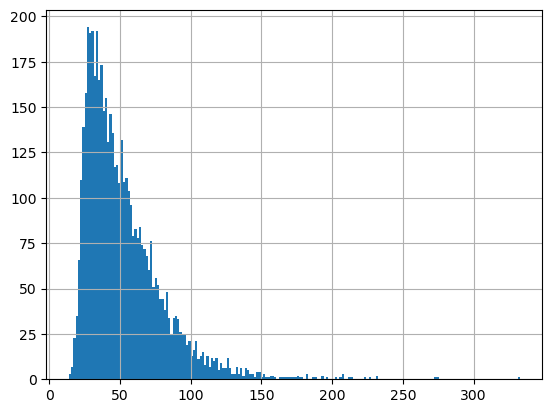

In [173]:
_ = simulated_values['VOT_public'].hist(bins=200)

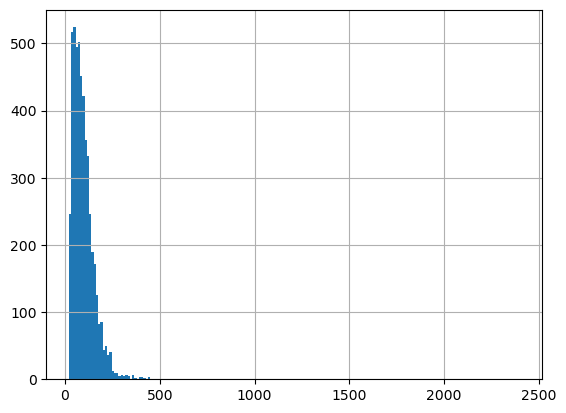

In [174]:
_ = simulated_values['VOT_driving'].hist(bins=200)

In [175]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

52.28020456020181

In [176]:
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_driving

97.26943094425545

In [177]:
print('Original scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.2f} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.2f} GBP/hour')

Original scenario:
Average value of time for Public Transport: 52.28 GBP/hour
Average value of time for Driving: 97.27 GBP/hour


In [178]:
# for the first scenario:
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving*1.15 + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent

vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results3.getBetaValues())


In [179]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

52.28020456020181

In [180]:
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()
avg_vot_driving

84.58211561813063

In [181]:
print('First scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.3g} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.3g} GBP/hour')

First scenario:
Average value of time for Public Transport: 52.3 GBP/hour
Average value of time for Driving: 84.6 GBP/hour


In [182]:
# for the second scenario:
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit*0.85 
V_driving = asc_driving + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving + beta_drivinglicense * driving_license +beta_traffic*driving_traffic_percent

vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results3.getBetaValues())

In [183]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()


In [184]:
print('First scenario:')
print(f'Average value of time for Public Transport: {avg_vot_pt:.3g} GBP/hour')
print(f'Average value of time for Driving: {avg_vot_driving:.3g} GBP/hour')

First scenario:
Average value of time for Public Transport: 61.5 GBP/hour
Average value of time for Driving: 97.3 GBP/hour


## Aggregate elasticity

Disaggregate elasticity
$$
E_{x_{i n k}}^{P_{n}(i)}=\frac{\partial P_{n}(i)}{\partial x_{i n k}} \frac{x_{i n k}}{P_{n}(i)}
$$
Aggregate elasticity
$$
\begin{aligned}
E_{x_{j k}}^{\widehat{x^{\prime}}(i)} & =\frac{\partial \widehat{W}(i)}{\partial x_{j k}} \frac{x_{j k}}{\widehat{W}(i)} \\
& =\frac{1}{S} \sum_{n=1}^{N} \omega_{n} \frac{P_{n}(i)}{P_{n}(i)} \frac{\partial P_{n}(i)}{\partial x_{j k}} \frac{S x_{j k}}{\sum_{\ell=1}^{N} \omega_{\ell} P_{\ell}(i)} \\
& =\frac{1}{\sum_{\ell=1}^{N} \omega_{\ell} P_{\ell}(i)} \sum_{n=1}^{N} \omega_{n} P_{n}(i) E_{x_{j n k}}^{P_{n}(i)} .
\end{aligned}
$$

In [185]:
def calculate_direct_elasticity(utility):
    
    prob_public = models.logit(utility, None, 3)
    prob_driving = models.logit(utility, None, 4)
    

    simulate = {
    'Weight': Weight,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving,
    'Dis. Elas. public': Derive(prob_public,'cost_transit') * cost_transit / prob_public,
    'Dis. Elas. driving': Derive(prob_driving, 'cost_driving') * cost_driving / prob_driving,
    }


    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results3.getBetaValues())
    
    simulated_values['Weighted public'] = simulated_values['Weight']*simulated_values['Prob. public']
    simulated_values['Weighted driving'] = simulated_values['Weight']*simulated_values['Prob. driving']
    
    norm_public = simulated_values['Weighted public'].sum()
    norm_driving = simulated_values['Weighted driving'].sum()

    Aggregate_elas_public = (simulated_values['Weighted public']*simulated_values['Dis. Elas. public']).sum()/norm_public
    Aggregate_elas_driving = (simulated_values['Weighted driving']*simulated_values['Dis. Elas. driving']).sum()/norm_driving

    return Aggregate_elas_public, Aggregate_elas_driving, norm_public, norm_driving

In [186]:
calculate_direct_elasticity(V)

(-0.06357862661254227,
 -0.05176602593885486,
 1812.8447830089067,
 2089.196388146758)

In [187]:
def calculate_cross_elasticity(utility):
    
    prob_public = models.logit(utility, None, 3)
    prob_driving = models.logit(utility, None, 4)
    

    simulate = {
    'Weight': Weight,
    'Prob. public': prob_public,
    'Prob. driving': prob_driving,
    'Dis. Elas. public': Derive(prob_public,'cost_driving') * cost_driving / prob_public,
    'Dis. Elas. driving': Derive(prob_driving, 'cost_transit') * cost_transit / prob_driving,
    }


    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(results3.getBetaValues())
    
    simulated_values['Weighted public'] = simulated_values['Weight']*simulated_values['Prob. public']
    simulated_values['Weighted driving'] = simulated_values['Weight']*simulated_values['Prob. driving']
    
    norm_public = simulated_values['Weighted public'].sum()
    norm_driving = simulated_values['Weighted driving'].sum()

    Aggregate_elas_public = (simulated_values['Weighted public']*simulated_values['Dis. Elas. public']).sum()/norm_public
    Aggregate_elas_driving = (simulated_values['Weighted driving']*simulated_values['Dis. Elas. driving']).sum()/norm_driving

    return Aggregate_elas_public, Aggregate_elas_driving, norm_public, norm_driving

In [188]:
calculate_cross_elasticity(V)

(0.0505044429043135,
 0.043875576709567335,
 1812.8447830089067,
 2089.196388146758)

# Some trials

In [ ]:
# ln transformation
V_walk = beta_time_walk * log(dur_walking)
V_cycling = asc_cycling + beta_time_cycling *log(dur_cycling)
V_public = asc_public + beta_time_public * log(dur_public)+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * log(dur_driving) + beta_cost * cost_driving \
            +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_ln'
results_ln = biogeme.estimate()
results_ln.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-1.707535,0.222356,-7.679269,1.598721e-14
asc_driving,1.187864,0.216566,5.485001,4.134664e-08
asc_public,1.882808,0.131913,14.273088,0.000000e+00
beta_cost,-0.095186,0.013893,-6.851416,7.312151e-12
beta_driving_traffic_percent,-2.709373,0.237143,-11.425077,0.000000e+00
beta_drivinglicense,1.433180,0.071798,19.961238,0.000000e+00
beta_time_cycling,-1.924807,0.129195,-14.898501,0.000000e+00
beta_time_driving,-1.522484,0.105308,-14.457412,0.000000e+00
beta_time_public,-1.528355,0.116170,-13.156217,0.000000e+00
beta_time_walk,-4.022205,0.125534,-32.040705,0.000000e+00


In [ ]:
# vot
vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')
simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results_ln.getBetaValues())

In [ ]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

57.75378188578838

In [ ]:
avg_vot_driving = (
    simulated_values['VOT_driving'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_driving

119.33472448938895